In [1]:
import torch
import os
import json
import re
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colors as colors
import importlib.util
from matplotlib.lines import Line2D
import perturbed_organics.utils as utils


# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [141]:
input_type = 'delocalized'
mu = "0.0"
mu_val = float(mu)
# input_scale = "linear"
input_scale = "log-scale"

# folder_path = f'/vast/sr6364/perturbed_organics/data/adaptive_main/{input_type}/'
folder_path = f'/vast/sr6364/perturbed_organics/data/adaptive_main/old_data/'

In [142]:
# This dictionary will map each tensor name (file name without .pt)
# to a dictionary that maps deltaval values to the loaded tensor.
all_data = {}

# Regular expression to capture a deltaval value at the end of the folder name.
# For example, if the folder name is "commonText_deltaval_1.0",
# this regex extracts "1.0".
# pattern = re.compile(r'_delta_([0-9\.]+)$')
pattern = re.compile(
    r'^(?=.*_mu_{})'
    r'.*_delta_([0-9\.]+)$'.format(re.escape(mu))
)

# pattern = re.compile(
#     r'^(?=.*_mu_{})'
#     r'.*_delta_([0-9\.]+)_{}$'.format(re.escape(mu), re.escape(input_scale))
# )

representative_subfolder = None
# Loop over all items in the main folder
for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.isdir(subfolder_path):
        match = pattern.search(subfolder)
        if match:
            representative_subfolder = subfolder
            # Convert the captured deltaval string to a float
            deltaval = float(match.group(1))
            
            # Loop over each file in the subfolder
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.pt'):
                    # Use the file name without the extension as the tensor name
                    tensor_name = os.path.splitext(filename)[0]
                    # Load the torch tensor from file
                    tensor = torch.load(os.path.join(subfolder_path, filename))
                    
                    # If this tensor name has not been seen before, create a new dictionary for it.
                    if tensor_name not in all_data:
                        all_data[tensor_name] = {}
                    
                    # Save the tensor in the inner dictionary with deltaval as key.
                    all_data[tensor_name][deltaval] = tensor

In [143]:
param_file_path = os.path.join(folder_path, representative_subfolder, 'parameters.json')
with open(param_file_path, 'r') as f:
    params = json.load(f)

# Extract parameters
N = params['N']
num_tasks = params['num_tasks']
num_delta = params['num_delta']
num_input = params['num_input']
num_trials = params['num_trials']
delta_range = np.array(params['delta_range'])
input_range = np.array(params['input_range'])

In [144]:
all_data.keys()

dict_keys(['actual_fixed_point_a', 'actual_fixed_point_y', 'condition', 'eigvals_J', 'first_order_perturb_a', 'first_order_perturb_y', 'norm_fixed_point_a', 'norm_fixed_point_y', 'spectral_radius'])

In [145]:
actual_fp_y_dict = all_data['actual_fixed_point_y']
norm_fp_y_dict = all_data['norm_fixed_point_y']
eigvals_dict = all_data['eigvals_J']

In [146]:
actual_fp_y_dict.keys()

dict_keys([0.05, 0.1, 0.2, 0.4, 0.8])

### We plot the mean and variance of the membrane potential for a given neuron as a function of input drive

In [147]:
idx = 0  # index of the neuron to plot the vals for

In [148]:
norm_sol_idx = []
for input_norm in input_range:
    z = utils.make_input_drive(N=N, input_type=params['model_name'], input_norm=input_norm)
    norm_eqn = torch.sqrt(z ** 2 / (params['sigma']**2 + torch.norm(z) ** 2))
    norm_sol_idx.append(norm_eqn[idx].item())
norm_sol_idx = np.array(norm_sol_idx)

# analytical solution for the mean of the fixed point
G = (1 - np.sqrt(params['sigma'] ** 2 + input_range ** 2)) / (params['sigma'] ** 2 + input_range ** 2)
analytical_mean = norm_sol_idx + mu_val * input_range * G * (1 - input_range ** 2 / (params['sigma'] ** 2 + input_range ** 2)) / np.sqrt(N)

In [ ]:
plt.figure(figsize=(8, 6))

# Get all the delta values and sort them (assuming they are numeric)
# delta_keys = sorted(actual_fp_y_dict.keys())
delta_keys = [1.0]
min_delta = min(delta_keys)
max_delta = max(delta_keys)

# calculte and plot the normalization curve
plot = plt.plot(input_range, analytical_mean, label=f"analytical curve", color='black', linewidth=2.5)

for i, delta_val in enumerate(delta_keys):
    actual_fp_y = actual_fp_y_dict[delta_val]
    norm_fixed_point_y = norm_fp_y_dict[delta_val]

    y_val = actual_fp_y[:, :, :, idx]

    # y_ratio_mean = torch.mean(y_ratio, dim=2)
    y_val_mean = torch.nanmean(y_val, dim=2)

    # y_val_std = torch.std(y_val, dim=2) / np.sqrt(num_trials)
    # y_val_std = torch.std(y_val, dim=2) 
    y_val_std = utils.nanstd(y_val, dim=2)

    # find the stable percentage for each input drive
    ratio_stable = torch.sum(~torch.isnan(y_val), dim=2) / num_trials

    # plot = plt.plot(input_range, y_val_mean[0, :], label=f"$\Delta = {delta_val}$", color=plt.cm.viridis(i / len(delta_keys)), linewidth=2.5)
    # plt.fill_between(input_range, y_val_mean[0, :] - y_val_std[0, :], y_val_mean[0, :] + y_val_std[0, :], alpha=0.3, color=plt.cm.viridis(i / len(delta_keys)))
    
    plot = plt.plot(input_range, y_val_mean[0, :], label=f"$\Delta = {delta_val}$", color='royalblue', linewidth=2.5)
    plt.fill_between(input_range, y_val_mean[0, :] - y_val_std[0, :], y_val_mean[0, :] + y_val_std[0, :], alpha=0.3, color='royalblue')

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"$y$", fontsize=22, rotation=0, labelpad=10)
plt.title(f"{input_type} input ($\mu$={mu})", fontsize=22)
# plot x axis logscale
plt.xscale('log')
# plt.ylim([-0.05, 2])
plt.legend(fontsize=16, loc='upper left')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
# save this plot
# plt.savefig(f'../figures/fig2/fig2_4.png', bbox_inches='tight')
plt.show()

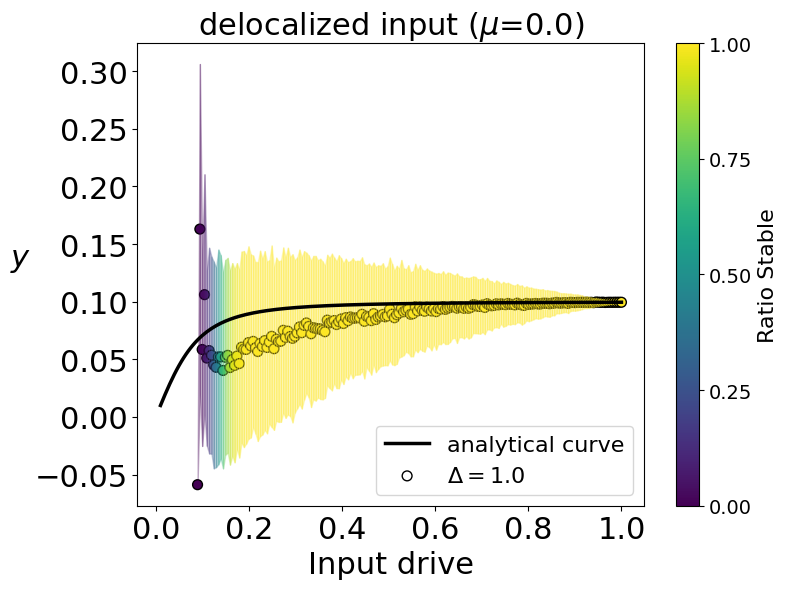

In [72]:
plt.figure(figsize=(8, 6))

# Use plasma colormap and normalize ratio_stable between 0 and 1
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=1)

# Get all the delta values and sort them (assuming they are numeric)
# delta_keys = sorted(actual_fp_y_dict.keys())
delta_keys = [1.0]
min_delta = min(delta_keys)
max_delta = max(delta_keys)

# plot the norm curve
plot = plt.plot(input_range, analytical_mean, label=f"analytical curve", color='black', linewidth=2.5)

for i, delta_val in enumerate(delta_keys):
    actual_fp_y = actual_fp_y_dict[delta_val]

    y_val = actual_fp_y[:, :, :, idx]

    # Calculate the mean and standard deviation along the 3rd dimension
    y_val_mean = torch.nanmean(y_val, dim=2)
    y_val_std = utils.nanstd(y_val, dim=2)

    # Calculate the percentage of stable points for each input drive
    ratio_stable = torch.sum(~torch.isnan(y_val), dim=2) / num_trials

    # Convert tensors to numpy arrays (if on GPU, first move them to CPU)
    x = np.array(input_range)
    y_mean = y_val_mean[0, :].cpu().numpy()
    y_std = y_val_std[0, :].cpu().numpy()
    r_stable = ratio_stable[0, :].cpu().numpy()

    # Scatter plot: each point’s color is determined by its corresponding ratio_stable value.
    # Removed edgecolor to prevent overlapping borders from darkening the color.
    sc = plt.scatter(x, y_mean, c=r_stable, cmap=cmap, norm=norm, s=50,
                     label=f"$\\Delta = {delta_val}$", edgecolors='k')

    # For the envelope, loop over consecutive pairs of points to fill between the mean ± std
    for j in range(len(x) - 1):
        seg_x = x[j:j+2]
        seg_y_lower = y_mean[j:j+2] - y_std[j:j+2]
        seg_y_upper = y_mean[j:j+2] + y_std[j:j+2]
        avg_ratio = np.mean(r_stable[j:j+2])
        seg_color = cmap(norm(avg_ratio))
        plt.fill_between(seg_x, seg_y_lower, seg_y_upper, color=seg_color, alpha=0.3)

# Add a colorbar for the scatter plot (showing ratio_stable from 0 to 1)
cbar = plt.colorbar(sc, ticks=np.linspace(0, 1, 5))
cbar.set_label("Ratio Stable", fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"$y$", fontsize=22, rotation=0, labelpad=10)
plt.title(f"{input_type} input ($\\mu$={mu})", fontsize=22)
if input_scale == "linear":
    plt.xscale('linear')
else:
    plt.xscale('log')
plt.legend(fontsize=16, loc='lower right')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.savefig(f'../figures/fig2/fig2_{input_type}_{delta_val}.png', bbox_inches='tight')
plt.savefig(f'../figures/fig2/fig2_{input_type}_{delta_val}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()

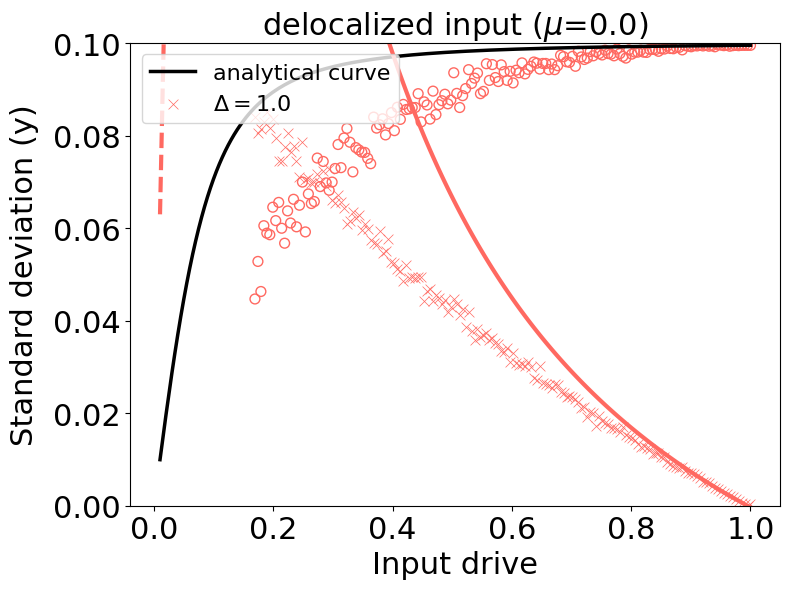

In [73]:
plt.figure(figsize=(8, 6))

stability_criterion_percent = 0.95

# Plot the norm_sol_idx curve (assumed to be a numpy array)
plt.plot(input_range, analytical_mean, label="analytical curve", color='black', linewidth=2.5)

delta_keys = [1.0, 1.5, 2.0, 2.5]
# delta_keys = [0.05, 0.1, 0.2, 0.4]
colors_to_use = ['#FF6961', plt.cm.viridis(1 / 3), plt.cm.viridis(2 / 3), '#FFA500',  '#FFA500'] 
min_delta = min(delta_keys)
max_delta = max(delta_keys)

idx_wanted = 0

for i, delta_val in enumerate(delta_keys):
    if not i==idx_wanted:
        continue

    actual_fp_y = actual_fp_y_dict[delta_val]

    y_val = actual_fp_y[:, :, :, idx]

    y_val_mean = torch.nanmean(y_val, dim=2)
    y_val_std = utils.nanstd(y_val, dim=2)

    # Calculate the percentage of stable points for each input drive
    ratio_stable = torch.sum(~torch.isnan(y_val), dim=2) / num_trials
    mask = (ratio_stable[0, :] > stability_criterion_percent).cpu().numpy()


    # plot the mean points
    plt.scatter(np.array(input_range)[mask], y_val_mean[0, :][mask], facecolors='none', s=50, edgecolors=colors_to_use[i], linewidths=1.0)

    # Plot the scatter of y_val_std points.
    plt.scatter(
        input_range[mask],
        y_val_std[0, :][mask],
        label=f"$\\Delta = {delta_val}$",
        color=colors_to_use[i],
        linewidth=0.5,
        s=50,
        marker='x'
    )

    # Calculate the analytical curve using the given formula.
    analytical_sd = delta_val * input_range * G / math.sqrt(2 * N) 

    # Determine where analytical_sd is greater than norm_sol_idx.
    diff = analytical_sd - norm_sol_idx
    condition = diff > 0  # True when analytical_sd > norm_sol_idx

    # Break the analytical curve into segments based on the condition.
    segments = []
    seg_x = [input_range[0]]
    seg_y = [analytical_sd[0]]
    current_cond = condition[0]

    for j in range(1, len(input_range)):
        new_cond = condition[j]
        if new_cond == current_cond:
            # Continue the segment if the condition hasn't changed.
            seg_x.append(input_range[j])
            seg_y.append(analytical_sd[j])
        else:
            # Condition changes between input_range[j-1] and input_range[j]:
            # Find the intersection point via linear interpolation.
            x0, x1 = input_range[j - 1], input_range[j]
            y0_a, y1_a = analytical_sd[j - 1], analytical_sd[j]
            y0_n, y1_n = norm_sol_idx[j - 1], norm_sol_idx[j]

            # Solve for t in [0,1] such that:
            # y0_a + t*(y1_a - y0_a) = y0_n + t*(y1_n - y0_n)
            t = (y0_n - y0_a) / ((y1_a - y0_a) - (y1_n - y0_n))
            x_int = x0 + t * (x1 - x0)
            y_int = y0_a + t * (y1_a - y0_a)

            # End the current segment at the intersection point.
            seg_x.append(x_int)
            seg_y.append(y_int)
            segments.append((seg_x, seg_y, current_cond))

            # Start a new segment starting at the intersection.
            seg_x = [x_int, input_range[j]]
            seg_y = [y_int, analytical_sd[j]]
            current_cond = new_cond

    # Append the last segment.
    segments.append((seg_x, seg_y, current_cond))

    # Plot each segment with the appropriate linestyle:
    # dashed if analytical_sd > norm_sol_idx, solid otherwise.
    for seg in segments:
        seg_x_data, seg_y_data, cond_flag = seg
        ls = '--' if cond_flag else '-'
        plt.plot(seg_x_data, seg_y_data, color=colors_to_use[i], linewidth=3.0, linestyle=ls)
        # plt.plot(seg_x_data, seg_y_data, color="#E65050", linewidth=3.0, linestyle=ls)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"Standard deviation (y)", fontsize=22, labelpad=10)
plt.title(f"{input_type} input ($\\mu$={mu})", fontsize=22)
if input_scale == "linear":
    plt.xscale('linear')
else:
    plt.xscale('log')
plt.legend(fontsize=16, loc='upper left')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim([0, 0.1])
plt.tight_layout()
plt.savefig(f'../figures/fig3/{input_type}_{delta_keys[idx_wanted]}.png', bbox_inches='tight')
plt.savefig(f'../figures/fig3/{input_type}_{delta_keys[idx_wanted]}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()


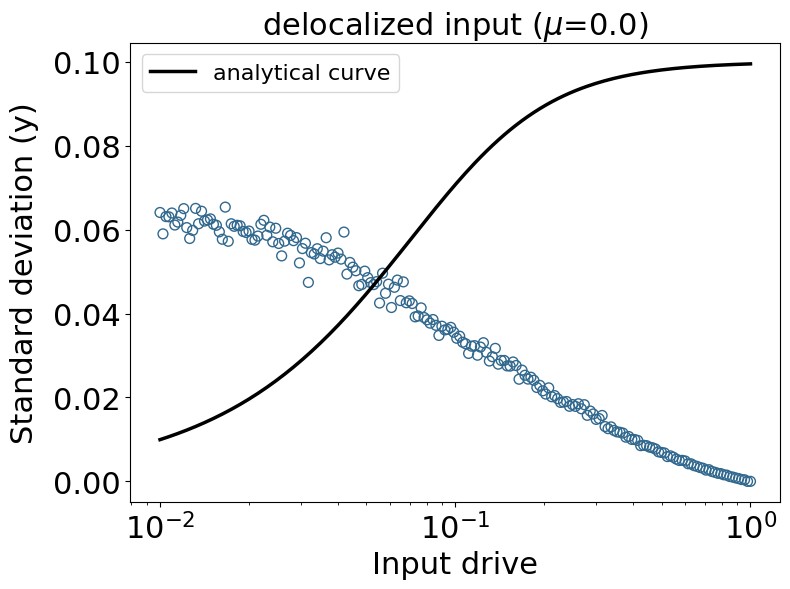

In [150]:
plt.figure(figsize=(8, 6))

stability_criterion_percent = 0.99

# Plot the norm_sol_idx curve (assumed to be a numpy array)
plt.plot(input_range, analytical_mean, label="analytical curve", color='black', linewidth=2.5)

# delta_keys = [1.0, 1.5, 2.0, 2.5]
delta_keys = [0.05, 0.1, 0.2, 0.4]
colors_to_use = ['#FF6961', plt.cm.viridis(1 / 3), plt.cm.viridis(2 / 3), '#FFA500',  '#FFA500'] 
min_delta = min(delta_keys)
max_delta = max(delta_keys)

idx_wanted = 1

for i, delta_val in enumerate(delta_keys):
    if not i==idx_wanted:
        continue

    actual_fp_y = actual_fp_y_dict[delta_val]
    norm_fixed_point_y = norm_fp_y_dict[delta_val]

    y_val = actual_fp_y[:, :, :, idx]
    norm_val = norm_fixed_point_y[:, :, :, idx]

    y_val_mean = torch.abs(torch.nanmean(y_val - norm_val, dim=2))
    y_val_std = utils.nanstd(y_val, dim=2)

    # Calculate the percentage of stable points for each input drive
    ratio_stable = torch.sum(~torch.isnan(y_val), dim=2) / num_trials
    mask = (ratio_stable[0, :] > stability_criterion_percent).cpu().numpy()
    
    val_plot = y_val_mean[0, :][mask] + y_val_std[0, :][mask]
    # plot the mean points
    plt.scatter(np.array(input_range)[mask], val_plot, facecolors='none', s=50, edgecolors=colors_to_use[i], linewidths=1.0)

    y_val_mean = torch.nanmean(y_val, dim=2)

    # plot the mean points
    # plt.scatter(np.array(input_range)[mask], y_val_mean[0, :][mask], facecolors='none', s=50, edgecolors='red', linewidths=1.0)

    # Plot the scatter of y_val_std points.
    # plt.scatter(
    #     input_range[mask],
    #     y_val_std[0, :][mask],
    #     label=f"$\\Delta = {delta_val}$",
    #     color=colors_to_use[i],
    #     linewidth=0.5,
    #     s=50,
    #     marker='x'
    # )

    # Calculate the analytical curve using the given formula.
    analytical_sd = delta_val * input_range * G / math.sqrt(2 * N) 

    # Determine where analytical_sd is greater than norm_sol_idx.
    diff = analytical_sd - norm_sol_idx
    condition = diff > 0  # True when analytical_sd > norm_sol_idx

    # Break the analytical curve into segments based on the condition.
    segments = []
    seg_x = [input_range[0]]
    seg_y = [analytical_sd[0]]
    current_cond = condition[0]

    for j in range(1, len(input_range)):
        new_cond = condition[j]
        if new_cond == current_cond:
            # Continue the segment if the condition hasn't changed.
            seg_x.append(input_range[j])
            seg_y.append(analytical_sd[j])
        else:
            # Condition changes between input_range[j-1] and input_range[j]:
            # Find the intersection point via linear interpolation.
            x0, x1 = input_range[j - 1], input_range[j]
            y0_a, y1_a = analytical_sd[j - 1], analytical_sd[j]
            y0_n, y1_n = norm_sol_idx[j - 1], norm_sol_idx[j]

            # Solve for t in [0,1] such that:
            # y0_a + t*(y1_a - y0_a) = y0_n + t*(y1_n - y0_n)
            t = (y0_n - y0_a) / ((y1_a - y0_a) - (y1_n - y0_n))
            x_int = x0 + t * (x1 - x0)
            y_int = y0_a + t * (y1_a - y0_a)

            # End the current segment at the intersection point.
            seg_x.append(x_int)
            seg_y.append(y_int)
            segments.append((seg_x, seg_y, current_cond))

            # Start a new segment starting at the intersection.
            seg_x = [x_int, input_range[j]]
            seg_y = [y_int, analytical_sd[j]]
            current_cond = new_cond

    # Append the last segment.
    segments.append((seg_x, seg_y, current_cond))

    # Plot each segment with the appropriate linestyle:
    # dashed if analytical_sd > norm_sol_idx, solid otherwise.
    for seg in segments:
        seg_x_data, seg_y_data, cond_flag = seg
        ls = '--' if cond_flag else '-'
        # plt.plot(seg_x_data, seg_y_data, color=colors_to_use[i], linewidth=3.0, linestyle=ls)
        # plt.plot(seg_x_data, seg_y_data, color="#E65050", linewidth=3.0, linestyle=ls)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"Standard deviation (y)", fontsize=22, labelpad=10)
plt.title(f"{input_type} input ($\\mu$={mu})", fontsize=22)
if input_scale == "linear":
    plt.xscale('linear')
else:
    plt.xscale('log')
plt.legend(fontsize=16, loc='upper left')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim([0, 0.1])
plt.tight_layout()
plt.savefig(f'../figures/fig3/{input_type}_{delta_keys[idx_wanted]}.png', bbox_inches='tight')
plt.savefig(f'../figures/fig3/{input_type}_{delta_keys[idx_wanted]}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()


In [110]:
val_plot

tensor([[0.6494, 0.6484, 0.6699, 0.6367, 0.6396, 0.6348, 0.6465, 0.6455, 0.6406,
         0.6572, 0.6504, 0.6426, 0.6641, 0.6436, 0.6279, 0.6582, 0.6523, 0.6406,
         0.6670, 0.6543, 0.6494, 0.6309, 0.6328, 0.6465, 0.6504, 0.6899, 0.6592,
         0.6631, 0.6426, 0.6738, 0.6494, 0.6528, 0.6582, 0.6616, 0.6729, 0.6621,
         0.6802, 0.6587, 0.6602, 0.6719, 0.6724, 0.6646, 0.6689, 0.6831, 0.6860,
         0.6992, 0.6963, 0.6846, 0.6855, 0.6938, 0.6909, 0.6943, 0.6816, 0.7153,
         0.6865, 0.7031, 0.7061, 0.7012, 0.6890, 0.7070, 0.7285, 0.7188, 0.7104,
         0.7188, 0.7310, 0.7188, 0.7148, 0.7202, 0.7305, 0.7363, 0.7231, 0.7427,
         0.7378, 0.7578, 0.7515, 0.7432, 0.7339, 0.7539, 0.7686, 0.7690, 0.7676,
         0.7749, 0.7690, 0.7715, 0.7793, 0.7749, 0.7837, 0.7949, 0.7949, 0.7886,
         0.8013, 0.7969, 0.7969, 0.7915, 0.8101, 0.8027, 0.8145, 0.8184, 0.8125,
         0.8198, 0.8130, 0.8306, 0.8335, 0.8311, 0.8340, 0.8442, 0.8325, 0.8394,
         0.8398, 0.8594, 0.8

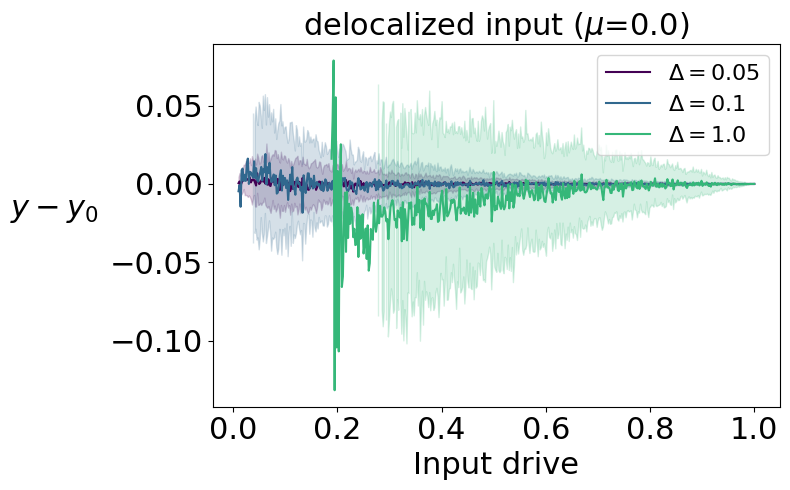

In [11]:
plt.figure(figsize=(8, 5))

idx = 0 # index of the neuron to plot the vals for

# Get all the delta values and sort them (assuming they are numeric)
# delta_keys = sorted(actual_fp_y_dict.keys())
delta_keys = [0.05, 0.1, 1.0]
min_delta = min(delta_keys)
max_delta = max(delta_keys)

for i, delta_val in enumerate(delta_keys):
    actual_fp_y = actual_fp_y_dict[delta_val]
    norm_fixed_point_y = norm_fp_y_dict[delta_val]

    y_val = actual_fp_y[:, :, :, idx] - norm_fixed_point_y[:, :, :, idx]

    # y_ratio_mean = torch.mean(y_ratio, dim=2)
    y_val_mean = torch.nanmean(y_val, dim=2)

    # y_val_std = torch.std(y_val, dim=2) / np.sqrt(num_trials)
    y_val_std = torch.std(y_val, dim=2) 

    plot = plt.plot(input_range, y_val_mean[0, :], label=f"$\Delta = {delta_val}$", color=plt.cm.viridis(i / len(delta_keys)))
    plt.fill_between(input_range, y_val_mean[0, :] - y_val_std[0, :], y_val_mean[0, :] + y_val_std[0, :], alpha=0.2, color=plt.cm.viridis(i / len(delta_keys)))

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"$y - y_0$", fontsize=22, rotation=0, labelpad=40)
plt.title(f"{input_type} input ($\mu$={mu})", fontsize=22)
# plt.ylim([-0.05, 2])
plt.legend(fontsize=16)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.show()

### Plot the mean and variance of the population

In [12]:
norm_sol = []
for input_norm in input_range:
    z = utils.make_input_drive(N=N, input_type=params['model_name'], input_norm=input_norm)
    norm_eqn = torch.sqrt(z ** 2 / (params['sigma']**2 + torch.norm(z) ** 2))
    norm_sol.append(torch.norm(norm_eqn).item())
norm_sol = np.array(norm_sol)

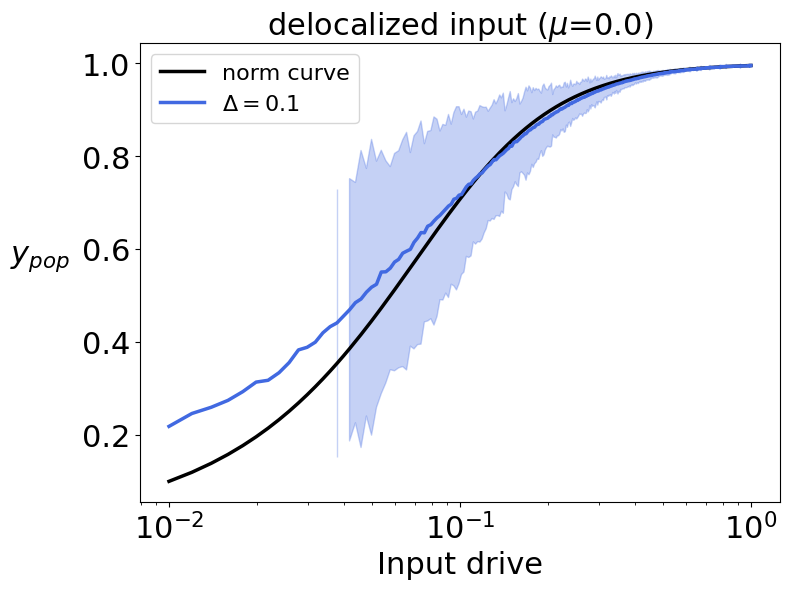

In [13]:
plt.figure(figsize=(8, 6))

# Get all the delta values and sort them (assuming they are numeric)
# delta_keys = sorted(actual_fp_y_dict.keys())
delta_keys = [0.1]
min_delta = min(delta_keys)
max_delta = max(delta_keys)

# calculte and plot the normalization curve
plot = plt.plot(input_range, norm_sol, label=f"norm curve", color='black', linewidth=2.5)

for i, delta_val in enumerate(delta_keys):
    actual_fp_y = actual_fp_y_dict[delta_val]
    pop_avg_y = torch.sum(actual_fp_y, dim=3) / math.sqrt(N)

    # y_ratio_mean = torch.mean(y_ratio, dim=2)
    y_val_mean = torch.nanmean(pop_avg_y, dim=2)

    # y_val_std = torch.std(y_val, dim=2) / np.sqrt(num_trials)
    y_val_std = torch.std(pop_avg_y, dim=2) * math.sqrt(N) ## multiplying the std by sqrt, check this 

    # plot = plt.plot(input_range, y_val_mean[0, :], label=f"$\Delta = {delta_val}$", color=plt.cm.viridis(i / len(delta_keys)), linewidth=2.5)
    # plt.fill_between(input_range, y_val_mean[0, :] - y_val_std[0, :], y_val_mean[0, :] + y_val_std[0, :], alpha=0.3, color=plt.cm.viridis(i / len(delta_keys)))

    plot = plt.plot(input_range, y_val_mean[0, :], label=f"$\Delta = {delta_val}$", color='royalblue', linewidth=2.5)
    plt.fill_between(input_range, y_val_mean[0, :] - y_val_std[0, :], y_val_mean[0, :] + y_val_std[0, :], alpha=0.3, color='royalblue')

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"$y_{pop}$", fontsize=22, rotation=0, labelpad=30)
plt.title(f"{input_type} input ($\mu$={mu})", fontsize=22)
# plot x axis logscale
plt.xscale('log')
# plt.ylim([-0.05, 2])
plt.legend(fontsize=16, loc='upper left')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
# save this plot
plt.savefig(f'../figures/fig2/fig2_2.png', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

# Get all the delta values and sort them (assuming they are numeric)
# delta_keys = sorted(actual_fp_y_dict.keys())
delta_keys = [0.05, 0.1]
min_delta = min(delta_keys)
max_delta = max(delta_keys)

for i, delta_val in enumerate(delta_keys):
    actual_fp_y = actual_fp_y_dict[delta_val]
    pop_avg_y = torch.sum(actual_fp_y, dim=3) / math.sqrt(N)

    y_val_std = torch.std(pop_avg_y, dim=2) * math.sqrt(N)

    # calculating these curves using flaviano's analytical solution

    plot = plt.scatter(input_range, y_val_std[0, :], label=f"$\Delta = {delta_val}$", color=plt.cm.viridis(i / len(delta_keys)), linewidth=1.0, s=50, marker='x')

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"Standard deviation (y)", fontsize=22, labelpad=10)
plt.title(f"{input_type} input ($\mu$={mu})", fontsize=22)
# plot x axis logscale
plt.xscale('log')
# plt.ylim([-0.05, 2])
plt.legend(fontsize=16, loc='upper right')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
# save this plot
plt.savefig(f'../figures/fig3/fig1.png', bbox_inches='tight')
plt.show()

### Plotting the ratio of away from normalization fixed point

In [ ]:

plt.figure(figsize=(8, 5))

# Get all the delta values and sort them (assuming they are numeric)
delta_keys = sorted(actual_fp_y_dict.keys())
min_delta = min(delta_keys)
max_delta = max(delta_keys)

for delta_val in delta_keys:
    actual_fp_y = actual_fp_y_dict[delta_val]
    norm_fixed_point_y = norm_fp_y_dict[delta_val]

    y1_squared_norm = torch.norm(norm_fixed_point_y - actual_fp_y, dim=3) ** 2
    y0_squared_norm = torch.norm(norm_fixed_point_y, dim=3) ** 2

    y_ratio = y1_squared_norm / y0_squared_norm
    y_ratio_mean = torch.nanmean(y_ratio, dim=2)
    y_ratio_std = torch.std(y_ratio, dim=2)
    
    
    # Normalize delta_val to the range [0, 1]
    if max_delta > min_delta:
        norm_val = (delta_val - min_delta) / (max_delta - min_delta)
    else:
        norm_val = 0  # Avoid division by zero if all delta values are the same
    
    # Map the normalized value to a grayscale intensity in the range [0, 0.25]
    # (0.25 is lightest; 0 is black)
    grayscale_value = 0.9 * (1 - norm_val)
    
    # Plot using the computed grayscale value. Matplotlib interprets strings like "0.25" as a grayscale color.
    plt.plot(input_range, y_ratio_mean[0, :],
             label=f"$\\Delta = {delta_val}$",
             linewidth=3,
             color=str(grayscale_value))
    
    plt.fill_between(input_range, y_ratio_mean[0, :] - y_ratio_std[0, :], y_ratio_mean[0, :] + y_ratio_std[0, :], alpha=0.2, color=str(grayscale_value))


plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"$\frac{||\mathbf{y}-\mathbf{y}_0||^2}{||\mathbf{y}_0||^2}$", fontsize=22, rotation=0, labelpad=50)
plt.title(f"{input_type} input ($\mu$={mu})", fontsize=22)
# plt.ylim([-0.05, 1])
plt.legend(fontsize=16)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))

# Get all the delta values and sort them (assuming they are numeric)
delta_keys = sorted(actual_fp_y_dict.keys())

for i, delta_val in enumerate(delta_keys):
    actual_fp_y = actual_fp_y_dict[delta_val]
    norm_fixed_point_y = norm_fp_y_dict[delta_val]

    y1_squared_norm = torch.norm(norm_fixed_point_y - actual_fp_y, dim=3) ** 2
    y0_squared_norm = torch.norm(norm_fixed_point_y, dim=3) ** 2

    y_ratio = y1_squared_norm / y0_squared_norm
    # y_ratio_mean = torch.mean(y_ratio, dim=2)
    y_ratio_mean = torch.nanmean(y_ratio, dim=2)

    ratio_stable = torch.sum(~torch.isnan(y_ratio), dim=2) / num_trials

    scatter = plt.scatter(input_range, y_ratio_mean[0, :], cmap='viridis', c=ratio_stable, vmin=0, vmax=1, s=3, marker='o')

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"$\frac{||\mathbf{y}-\mathbf{y}_0||^2}{||\mathbf{y}_0||^2}$", fontsize=22, rotation=0, labelpad=50)
plt.title(f"{input_type} input ($\mu$={mu})", fontsize=22)
cbar = plt.colorbar(scatter)
cbar.set_label('Ratio stable')
plt.ylim([-0.05, 2])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.show()

### Now we plot the upper plots but the ratio is calculated with respect to the mean of the simulation itself

In [ ]:

plt.figure(figsize=(8, 5))

# Get all the delta values and sort them (assuming they are numeric)
delta_keys = sorted(actual_fp_y_dict.keys())
min_delta = min(delta_keys)
max_delta = max(delta_keys)

for delta_val in delta_keys:
    actual_fp_y = actual_fp_y_dict[delta_val]
    avg_actual_fp_y = torch.nanmean(actual_fp_y, dim=2, keepdim=True)

    y1_squared_norm = torch.norm(avg_actual_fp_y - actual_fp_y, dim=3) ** 2
    y0_squared_norm = torch.norm(avg_actual_fp_y, dim=3) ** 2

    y_ratio = y1_squared_norm / y0_squared_norm
    y_ratio_mean = torch.nanmean(y_ratio, dim=2)
    y_ratio_std = torch.std(y_ratio, dim=2)
    
    
    # Normalize delta_val to the range [0, 1]
    if max_delta > min_delta:
        norm_val = (delta_val - min_delta) / (max_delta - min_delta)
    else:
        norm_val = 0  # Avoid division by zero if all delta values are the same
    
    # Map the normalized value to a grayscale intensity in the range [0, 0.25]
    # (0.25 is lightest; 0 is black)
    grayscale_value = 0.9 * (1 - norm_val)
    
    # Plot using the computed grayscale value. Matplotlib interprets strings like "0.25" as a grayscale color.
    plt.plot(input_range, y_ratio_mean[0, :],
             label=f"$\\Delta = {delta_val}$",
             linewidth=3,
             color=str(grayscale_value))
    
    plt.fill_between(input_range, y_ratio_mean[0, :] - y_ratio_std[0, :], y_ratio_mean[0, :] + y_ratio_std[0, :], alpha=0.2, color=str(grayscale_value))


plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"$\frac{||\mathbf{y}-\mathbf{y}_0||^2}{||\mathbf{y}_0||^2}$", fontsize=22, rotation=0, labelpad=50)
plt.title(f"{input_type} input ($\mu$={mu})", fontsize=22)
# plt.ylim([-0.05, 1])
plt.legend(fontsize=16)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))

# Get all the delta values and sort them (assuming they are numeric)
delta_keys = sorted(actual_fp_y_dict.keys())

for i, delta_val in enumerate(delta_keys):
    actual_fp_y = actual_fp_y_dict[delta_val]
    avg_actual_fp_y = torch.nanmean(actual_fp_y, dim=2, keepdim=True)

    y1_squared_norm = torch.norm(avg_actual_fp_y - actual_fp_y, dim=3) ** 2
    y0_squared_norm = torch.norm(avg_actual_fp_y, dim=3) ** 2

    y_ratio = y1_squared_norm / y0_squared_norm
    # y_ratio_mean = torch.mean(y_ratio, dim=2)
    y_ratio_mean = torch.nanmean(y_ratio, dim=2)

    ratio_stable = torch.sum(~torch.isnan(y_ratio), dim=2) / num_trials

    scatter = plt.scatter(input_range, y_ratio_mean[0, :], cmap='viridis', c=ratio_stable, vmin=0, vmax=1, s=3, marker='o')

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"$\frac{||\mathbf{y}-\mathbf{\hat{y}}||^2}{||\mathbf{\hat{y}}||^2}$", fontsize=22, rotation=0, labelpad=50)
plt.title(f"{input_type} input ($\mu$={mu})", fontsize=22)
cbar = plt.colorbar(scatter)
cbar.set_label('Ratio stable')
plt.ylim([-0.05, 2])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.savefig(f'../figures/fig2.5/fig1.png', bbox_inches='tight')
plt.show()

### Plotting the max real part of eigenvalue of the jacobian

In [ ]:
plt.figure(figsize=(8, 5))

# Get all the delta values and sort them (assuming they are numeric)
delta_keys = sorted(eigvals_dict.keys())
min_delta = min(delta_keys)
max_delta = max(delta_keys)

for delta_val in delta_keys:
    eigvals_J = eigvals_dict[delta_val]
    eigvals_J_real = torch.max(torch.real(eigvals_J), dim=3).values
    eigvals_J_real_mean = torch.mean(eigvals_J_real, dim=2)
    # eigvals_J_real_mean = torch.nanmean(eigvals_J_real, dim=2)
    # eigvals_J_real_mean = torch.max(eigvals_J_real, dim=2).values

    eigvals_J_real_std = torch.std(eigvals_J_real, dim=2) 
    
    # Normalize delta_val to the range [0, 1]
    if max_delta > min_delta:
        norm_val = (delta_val - min_delta) / (max_delta - min_delta)
    else:
        norm_val = 0  # Avoid division by zero if all delta values are the same
    
    # Map the normalized value to a grayscale intensity in the range [0, 0.25]
    # (0.25 is the lightest color; 0 is black)
    grayscale_value = 0.9 * (1 - norm_val)
    
    # Plot using the computed grayscale value. Matplotlib interprets strings like "0.25" as a grayscale color.
    plt.plot(input_range, eigvals_J_real_mean[0, :],
             label=f"$\\Delta = {delta_val}$",
             linewidth=3,
             color=str(grayscale_value))

    plt.fill_between(input_range, eigvals_J_real_mean[0, :] - eigvals_J_real_std[0, :], eigvals_J_real_mean[0, :] + eigvals_J_real_std[0, :], alpha=0.2, color=str(grayscale_value))


plt.xlabel('Input drive', fontsize=22)
plt.ylabel(f"$max(Re(\\lambda))$", fontsize=22, rotation=90, labelpad=10)
plt.title(f"{input_type} input ($\mu$={mu})", fontsize=22)
plt.gca().set_ylim(top=0)
plt.legend(fontsize=16)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.show()

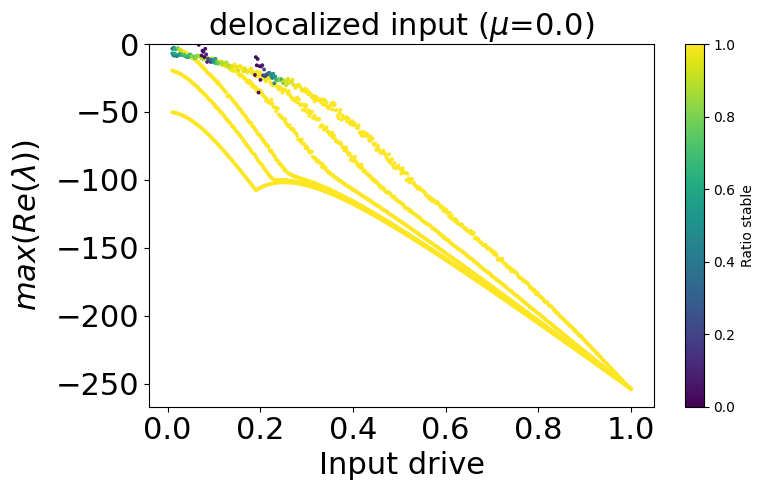

In [16]:
plt.figure(figsize=(8, 5))

# Get all the delta values and sort them (assuming they are numeric)
delta_keys = sorted(eigvals_dict.keys())

for delta_val in delta_keys:
    eigvals_J = eigvals_dict[delta_val]
    eigvals_J_real = torch.max(torch.real(eigvals_J), dim=3).values

    ratio_stable = torch.sum(~torch.isnan(eigvals_J_real), dim=2) / num_trials

    # eigvals_J_real_mean = torch.mean(eigvals_J_real, dim=2)
    eigvals_J_real_mean = torch.nanmean(eigvals_J_real, dim=2)
    # eigvals_J_real_mean = torch.max(torch.nan_to_num(eigvals_J_real, nan=-float('inf')), dim=2).values
    
    scatter = plt.scatter(input_range, eigvals_J_real_mean[0, :], cmap='viridis', c=ratio_stable, vmin=0, vmax=1, s=3, marker='o')


plt.xlabel('Input drive', fontsize=22)
plt.ylabel(f"$max(Re(\\lambda))$", fontsize=22, rotation=90, labelpad=10)
plt.title(f"{input_type} input ($\mu$={mu})", fontsize=22)
cbar = plt.colorbar(scatter)
cbar.set_label('Ratio stable')
plt.gca().set_ylim(top=0)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.savefig(f'../figures/fig2.5/fig2.png', bbox_inches='tight')
plt.show()